# Computation HW #4

In [1]:
# Setup 
import numpy as np
import matplotlib.pyplot as plt
my_randState=np.random.RandomState(seed=1244351)

### Problem 2 - adapted from code from class

In [2]:
# Sampler with Gaussian density function (posterior)
# Input: x value to be sampled at, optional mean and variance of the Gaussian
def sample_f(x, mean=2, var=2):
    return np.exp(-(x-mean)**2/(2*var) / (np.sqrt(2*np.pi*var)))

In [63]:
# Simple MH-MCMC sampler 
def basic_MH_MCMC(nsteps, x0, mean=2, var=2, scale=1):
    samples = np.zeros(nsteps)
    uniforms = my_randState.random(nsteps)

    xi = x0

    for i in range(nsteps):
        # sample current step
        pcurr = sample_f(xi, mean=mean, var=var)
        if (pcurr == 0): # check for zeros
            pcurr = 1e-10

        # draw next step from proposal - allow std to change for question 3
        xnew = np.random.normal(loc=xi, scale=scale)
        # sample new step
        pnew = sample_f(xnew, mean=mean, var=var)
        # accept-reject 
        if (pnew/pcurr > uniforms[i]):
            xi = xnew

        samples[i] = xi

    return samples

### Problem 9

Modify the sampler you wrote in Problem 2 to take steps not in x but  in ln x.

In [20]:
# Simple MH-MCMC sampler that takes steps in ln(x) 
# INPUT: number of steps and inital value
# RETURNS: chain of samples
def ln_MH_MCMC(nsteps, x0):
    samples = np.zeros(nsteps)
    uniforms = my_randState.random(nsteps)

    # Save xi not in log-step (to re-use sample_f function)
    xi = np.exp(x0)

    for i in range(nsteps):
        # Evalulate in log-space
        pcurr = sample_f(np.log(xi))

        # Take step in log-space, then un-log
        xnew = np.exp(np.log(xi) + np.random.randn())
        pnew = sample_f(np.log(xnew))

        # Accept-reject step 
        if uniforms[i] <= pnew/pcurr:
            xi = xnew
            pcurr = pnew
        samples[i] = xi

    return samples

/var/folders/9n/z5456p4n4k71bdvhgh74hrmr0000gq/T/ipykernel_28575/569569019.py:13: RuntimeWarning: divide by zero encountered in log
  ax.plot(x, sample_f(np.log(x)) / x, label='Analytic')
/var/folders/9n/z5456p4n4k71bdvhgh74hrmr0000gq/T/ipykernel_28575/569569019.py:13: RuntimeWarning: invalid value encountered in divide
  ax.plot(x, sample_f(np.log(x)) / x, label='Analytic')


(0.0, 20.0)

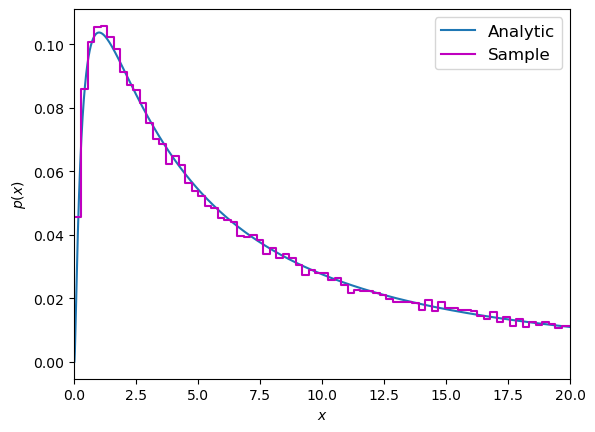

In [32]:
# Setup inputs
nsteps = 10**5
x0 = 0

# Call sampler
samples = ln_MH_MCMC(nsteps, x0)

# Plot results
fig, ax = plt.subplots(1, 1)

# Analytic function we have sampled from 
x = np.linspace(0, 20, 5000)
ax.plot(x, sample_f(np.log(x)) / x, label='Analytic')

# Make histogram of samples
h1 = np.histogram(samples, bins=10000, density=True)
hx = np.zeros(h1[0].size*2)
hy = np.zeros(h1[0].size*2)
hx[::2] = h1[1][:-1]
hx[1::2] = h1[1][1:]
hy[::2] = h1[0]
hy[1::2] = h1[0]
plt.plot(hx, hy, 'm-', label='Sample')

ax.set_xlabel("$x$")
ax.set_ylabel("$p(x)$")
ax.legend(fontsize=12)
ax.set_xlim([0,20])

We are no longer sampling in the Gaussian from Problem 2. We now have a broader distribution, but still peaking at x=2. Now our inputs are logged, and so we are sampling in the previous Gaussian but inputting log-values and dividing by the derivative of those log-function input (1/x). Therefore we are sampling in log(previous Gaussian)/x.

### Problem 10

Re-do Problem 2 but now look at convergence: Plot the x chain as  a function of timestep. Also split the chain into four contiguous segments and compute the mean and empirical variance in each. 

Chain 0: 
	 mean: 2.027
	 var: 1.933
Chain 1: 
	 mean: 2.038
	 var: 1.964
Chain 2: 
	 mean: 1.991
	 var: 2.044
Chain 3: 
	 mean: 1.994
	 var: 2.013


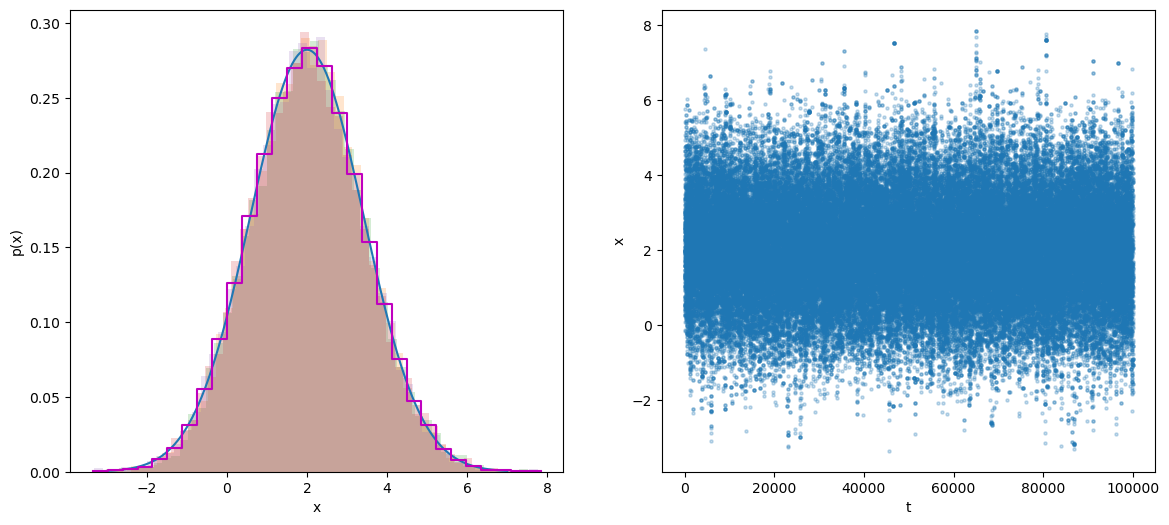

In [49]:
# Initial setup
nsteps = 10**5
x0 = 0

# Run basic sampler, same as problem 2
samples = basic_MH_MCMC(nsteps, x0)

# Plot histograms of each segment and x-chain over time
fig, ax = plt.subplots(1, 2, figsize=(14,6))

# Plot analytic function
xvals = np.linspace(-3, 7, 5000)
ax[0].plot(xvals, [sample_f(x) for x in xvals])

# Plot overall histogram of chain
h1 = np.histogram(samples, bins=30, density=True)
hx = np.zeros(h1[0].size*2)
hy = np.zeros(h1[0].size*2)
hx[::2] = h1[1][:-1]
hx[1::2] = h1[1][1:]
hy[::2] = h1[0]
hy[1::2] = h1[0]
ax[0].plot(hx, hy, 'm-')
ax[0].set_xlabel('x')
ax[0].set_ylabel('p(x)')

# Plot chain as a function of timestep
ax[1].scatter(np.arange(nsteps), samples, s=5, alpha=0.25)
ax[1].set_xlabel('t')
ax[1].set_ylabel('x')

# Split chain into four contiguous segments
for i in range(4):
    start = int(i*nsteps/4)
    stop = int((i+1)*nsteps/4)

    print('Chain %0.0f: '%i)
    print('\t mean: %0.3f'%(np.mean(samples[start:stop])))
    print('\t var: %0.3f'%(np.var(samples[start:stop])) )
    ax[0].hist(samples[start:stop], 50, alpha=0.2, density=True)

In each of the four chain segments, the mean and variances are very similar. This indicates that the chain has converged in each segment.

### Problem 11

Write a piece of code that computes the empirical autocorrelation function. Run this on the chain you obtained from Problem 2. Plot the autocorrelation function you find at short lags (∆ < 100)

In [83]:
# Empricial autocorrelation function 
# Code adapted from cited reference in Hogg - https://dfm.io/posts/autocorr/ to use FFT to speed up calculation
def autocorr(x):
    N = len(x)
    # Use fast fourier transform to compute c_f, faster than directly computing sum
    f = np.fft.fft(x - np.mean(x))
    # Inverse fourier transform
    acf = np.fft.ifft(f*np.conjugate(f))
    return acf/acf[0] # normalize


<>:17: SyntaxWarning: invalid escape sequence '\D'
<>:18: SyntaxWarning: invalid escape sequence '\D'
<>:17: SyntaxWarning: invalid escape sequence '\D'
<>:18: SyntaxWarning: invalid escape sequence '\D'
/var/folders/9n/z5456p4n4k71bdvhgh74hrmr0000gq/T/ipykernel_28575/1753953242.py:17: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta$')
/var/folders/9n/z5456p4n4k71bdvhgh74hrmr0000gq/T/ipykernel_28575/1753953242.py:18: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$C_x(\Delta)$')


Text(0, 0.5, '$C_x(\\Delta)$')

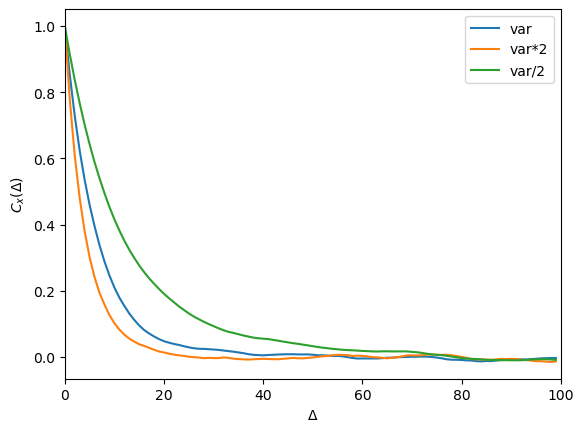

In [86]:
# Autocorrelation on chain from problem 2
C = autocorr(samples)
plt.plot(C[:100], label='var')

# now changing the proposal distribution to have variance 2x larger
samples2 = basic_MH_MCMC(nsteps, x0, scale=np.sqrt(2))
C2 = autocorr(samples2)
plt.plot(C2[:100], label='var*2')

# now changing the proposal distribution to have variance 2x smaller
samplesh = basic_MH_MCMC(nsteps, x0, scale=np.sqrt(1/2))
Ch = autocorr(samplesh)
plt.plot(Ch[:100], label='var/2')

plt.legend()
plt.xlim(0,100)
plt.xlabel('$\Delta$')
plt.ylabel('$C_x(\Delta)$')

Autocorrelation time is shorter for proposal distribution with larger variance. Each suggested step has a wider range of possible values, and a walker travels across the parameter space quicker, thus "forgetting" where it came from quicker.